# MLP - Pollution

## 1 - Introduction

Proof of concept about fitting a model with the following restrictions: 

1. The dataset must be **multivariate**

2. The dependant variable should **not have stationality**, but the regressors can.
3. The prediction must be done **without providing exogenous regressors** in any point of the "future"

Point 3 its essential since makes well known statisticall models such as SARIMAX and Prophet out of the game. In order to solve this problem we need to use deep learning techniques in an conveniently adapted dataset.

In this notebook I will implement the most basic model: the MLP on the Pollution dataset.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
def split_sequences(sequences, target, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences.iloc[i:end_ix, :-1], sequences[target].iloc[end_ix-1:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

## 2 - Loading data

In [20]:
dataset = pd.read_csv('./data/pollution.csv')

`Wind dir` and `date` requires a special manipulation since they are categorical and time-indexed variables respectively. 

The transformations may be the following : 

- Wind dir : dummy variable transform encoding as numeric.
- date : encoding as sinusoidal wave.

But, for this time, the specials features will be omited.

In [3]:
dataset = dataset.drop(["date", "wnd_dir"], axis = 1)

In [4]:
dataset.head()

,pollution,dew,temp,press,wnd_spd,snow,rain
0,129.0,-16,-4.0,1020.0,1.79,0,0
1,148.0,-15,-4.0,1020.0,2.68,0,0
2,159.0,-11,-5.0,1021.0,3.57,0,0
3,181.0,-7,-5.0,1022.0,5.36,1,0
4,138.0,-7,-5.0,1022.0,6.25,2,0


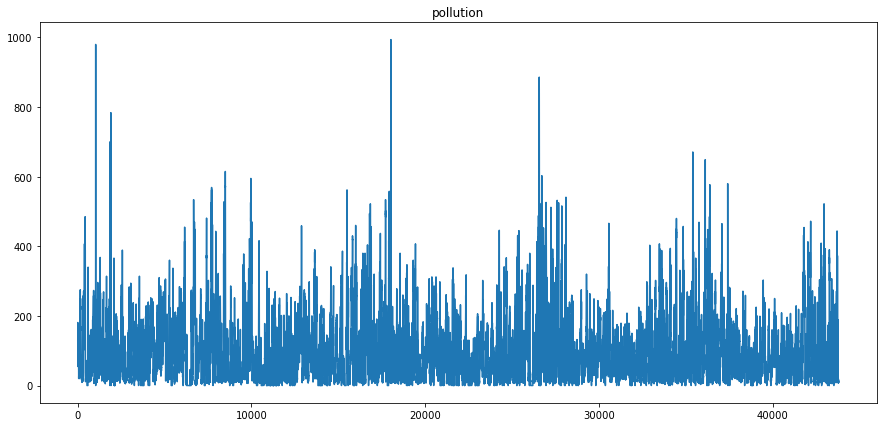

In [5]:
fig, ax = plt.subplots(figsize = (15,7))
plt.plot(dataset['pollution'])
plt.title('pollution')
plt.show()

In [6]:
dataset.shape

(43800, 7)

## 3 - Feature engineering

Normalization is always advised, we leave unchanged the target var :

In [7]:
numeric_vars = ['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']
dataset[numeric_vars] = (dataset[numeric_vars] - dataset[numeric_vars].mean())/dataset[numeric_vars].std()
dataset

,pollution,dew,temp,press,wnd_spd,snow,rain
0,129.0,-1.235575,-1.349834,0.345882,-0.441885,-0.069371,-0.137704
1,148.0,-1.166272,-1.349834,0.345882,-0.424093,-0.069371,-0.137704
2,159.0,-0.889059,-1.431845,0.443239,-0.406301,-0.069371,-0.137704
3,181.0,-0.611845,-1.431845,0.540597,-0.370518,1.245411,-0.137704
4,138.0,-0.611845,-1.431845,0.540597,-0.352726,2.560194,-0.137704
...,...,...,...,...,...,...,...
43795,8.0,-1.720698,-1.185810,1.708888,4.159623,-0.069371,-0.137704
43796,10.0,-1.651395,-1.267822,1.708888,4.275770,-0.069371,-0.137704
43797,10.0,-1.651395,-1.267822,1.708888,4.374125,-0.069371,-0.137704
43798,8.0,-1.651395,-1.349834,1.708888,4.454489,-0.069371,-0.137704


# 4 - Forward validation

Golden standard in time series

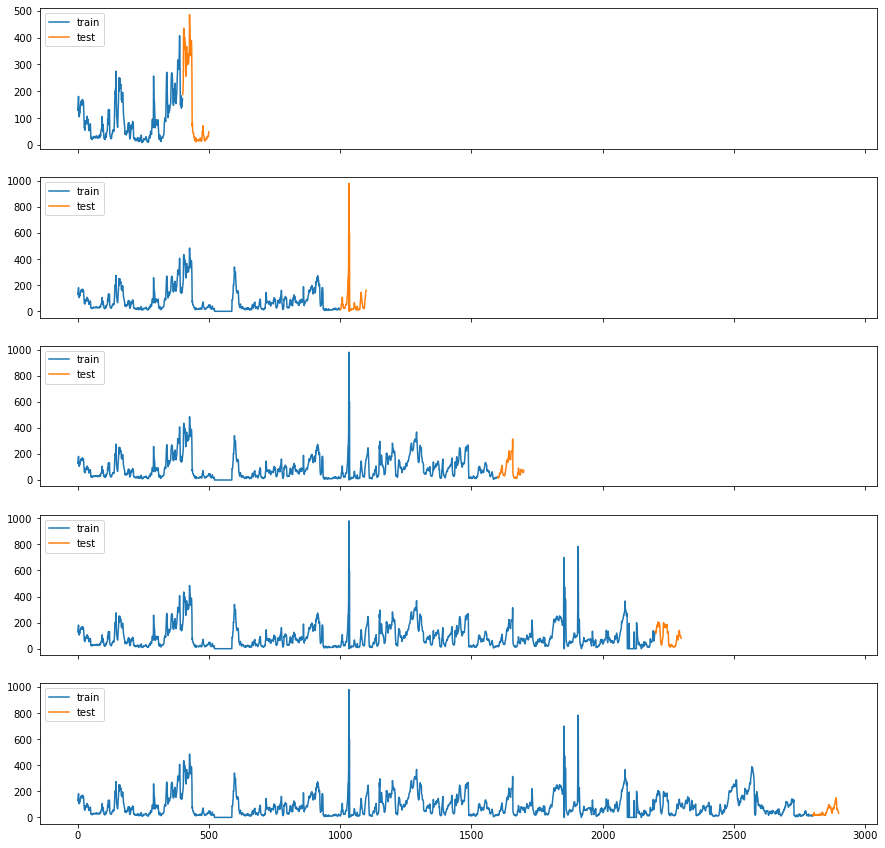

In [21]:
n_chunks = 5 # this governs the number of validation steps
n_steps_in, n_steps_out = 300, 100
backcast_size = 500
fig, axs = plt.subplots(n_chunks, 1, figsize = (15, 15), sharex = True)

for i, ax in zip(range(backcast_size, dataset.shape[0], backcast_size+n_steps_out), axs.ravel()):
    chunk_dataset = dataset.iloc[0:i]
    train = chunk_dataset['pollution'].iloc[0:i-n_steps_out]
    test  = chunk_dataset['pollution'].iloc[i-n_steps_out:i]
    ax.plot(train, label = "train")
    ax.plot([None for i in range(train.shape[0])] + [x for x in test], label = "test")
    ax.legend(loc = "upper left")

Note the test length fixed (`n_steps_out`), only the trainig sets changes, but the MLP window will be the same -> `n_steps_in`.

In [9]:
mse_list = []
y_pred_list = []
for i, ax in zip(range(backcast_size, dataset.shape[0], backcast_size+n_steps_out), axs.ravel()):
    chunk_dataset = dataset.iloc[0:i]

    # Train set
    X_train, y_train = split_sequences(sequences = chunk_dataset,
                                       target = "pollution",
                                       n_steps_in = n_steps_in,
                                       n_steps_out = n_steps_out)
    
    print(X_train.shape)
    print(y_train.shape)
    
    n_input = X_train.shape[1] * X_train.shape[2]
    X_train = X_train.reshape((X_train.shape[0], n_input))
    print("n_input : %d" % n_input)

    
    X_test, y_test = X_train[-1].reshape(1,n_input), y_train[-n_steps_out]
    
    # define model
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=n_input))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(X_train, y_train, epochs=1000, verbose=0)
    
    # predict
    y_pred = model.predict(X_train[-1].reshape(1,n_input), verbose=0)
    
    # update metrics
    y_pred_list.append(y_pred[0])
    mse_list.append(mean_squared_error(y_pred[0], y_test))

(102, 300, 6)
(102, 100)
n_input : 1800


2022-07-15 23:58:33.301182: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-15 23:58:33.343532: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-15 23:58:33.360208: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2894515000 Hz


(702, 300, 6)
(702, 100)
n_input : 1800
(1302, 300, 6)
(1302, 100)
n_input : 1800
(1902, 300, 6)
(1902, 100)
n_input : 1800
(2502, 300, 6)
(2502, 100)
n_input : 1800


Once the model is fitted in all the steps we can take a look at the forecasts: 

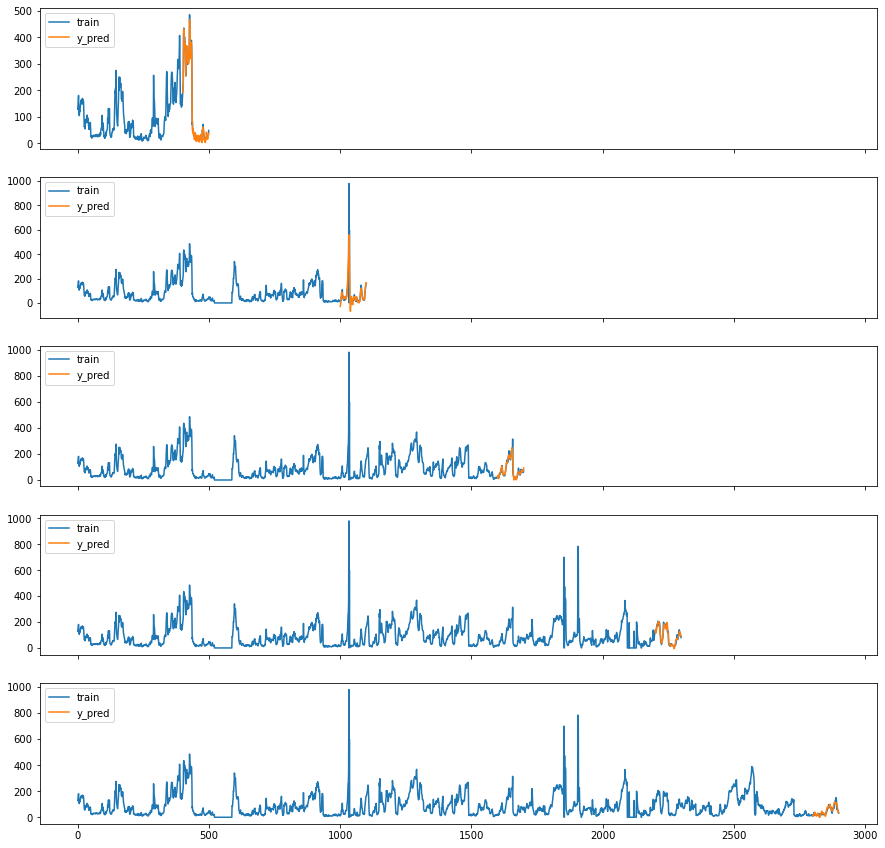

In [10]:
index = 0
fig, axs = plt.subplots(n_chunks, 1, figsize = (15, 15), sharex = True)
for i, ax in zip(range(backcast_size, dataset.shape[0], backcast_size+n_steps_out), axs.ravel()):
    chunk_dataset = dataset.iloc[0:i]
    train = chunk_dataset['pollution'].iloc[0:i-n_steps_out]
    test  = chunk_dataset['pollution'].iloc[i-n_steps_out:i]
    ax.plot( chunk_dataset['pollution'], label = "train")
    ax.plot([None for i in range(train.shape[0])] + [x for x in y_pred_list[index]], label = "y_pred")
    ax.legend(loc = "upper left")
    index = index + 1

Since the first step, the models behaves pretty good. Now we can take a look at the MSE : 

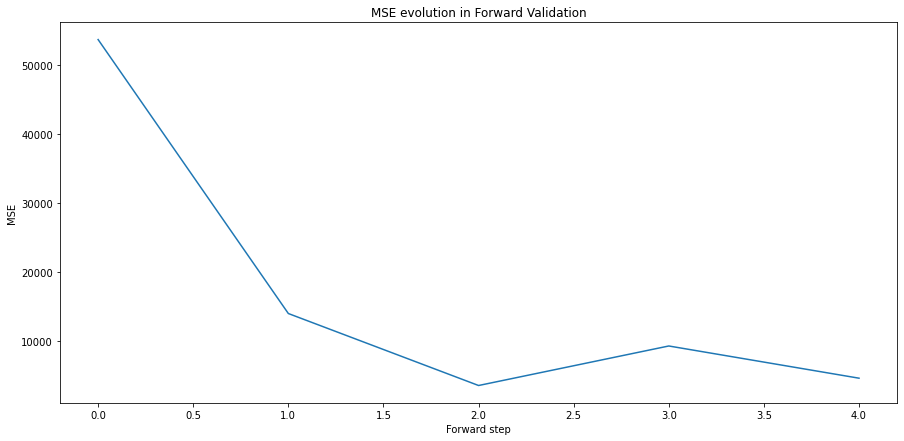

In [19]:
fig, axs = plt.subplots(1, 1, figsize = (15, 7), sharex = True)
plt.plot(mse_list)
plt.title("MSE evolution in Forward Validation")
plt.xlabel("Forward step")
plt.ylabel("MSE")
plt.show()

Seems reasonable, the MSE is decreasing as the model is able to see more an more data in the trainig as the validtion steps increases.

**The results looks to good to be true, more research is needed to confirm**